# Test EOF reconstructions

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import pathlib
import os
import src.utils
import cartopy.crs as ccrs
import cmocean

## initialize RNG
rng = np.random.default_rng(seed=100)

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])

## Load data

In [2]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th_mpi = xr.open_dataset(mpi_load_fp)

## EOFs (only do sst)
eofs_fp = pathlib.Path(DATA_FP, "mpi", "eofs300")
eofs_sst = src.utils.load_eofs(eofs_fp / "ts.nc")
eofs_ssh = src.utils.load_eofs(eofs_fp / "ssh.nc")

## for convenience, put components and scores into datasets
components = xr.merge(
    [eofs_sst.components().rename("sst"), eofs_ssh.components().rename("ssh")]
)
scores = xr.merge([eofs_sst.scores().rename("sst"), eofs_ssh.scores().rename("ssh")])

## Compute anomalies

In [3]:
emean, anom = src.utils.separate_forced(scores, n=0)

## Tests

### Identity reconstruction

In [4]:
## get random subset for testing
sample = scores.isel(member=slice(2, 4), time=slice(24, 60))

## identity function
identity = lambda x: x

## reconstruct 2 different ways
r0 = eofs_sst.inverse_transform(sample["sst"])
r1 = src.utils.reconstruct_fn(components["sst"], sample["sst"], fn=identity)

## check allclose
print(f"All close? {np.max(np.abs(r0-r1)).values < 1e-10}")

All close? True


### Niño 3.4 reconstruction

#### anomalies

In [5]:
## next, nino 34
n34_r0 = src.utils.get_nino34(r0)
n34_r1 = src.utils.reconstruct_fn(
    eofs_sst.components(), sample["sst"], fn=src.utils.get_nino34
)
print(f"All close? {np.allclose(n34_r0, n34_r1)}\n")

## get reconstruction error on full dataset
n34_recon = src.utils.reconstruct_fn(
    components["sst"], anom["sst"], fn=src.utils.get_nino34
)
h_recon = src.utils.reconstruct_fn(
    components["ssh"], anom["ssh"], fn=src.utils.get_RO_h
)
hw_recon = src.utils.reconstruct_fn(
    components["ssh"], anom["ssh"], fn=src.utils.get_RO_hw
)

## compute correlation with non-truncated data
corr_n34 = xr.corr(n34_recon, Th_mpi["T_34"].sel(time=n34_recon.time))
corr_h = xr.corr(h_recon, Th_mpi["h"].sel(time=n34_recon.time))
corr_hw = xr.corr(hw_recon, Th_mpi["h_w"].sel(time=n34_recon.time))

print(f"Corr w/ non-truncated Niño 3.4 index: {corr_n34:.5f}")
print(f"Corr w/ non-truncated h index:        {corr_h:.5f}")
print(f"Corr w/ non-truncated hw index:       {corr_hw:.5f}")

All close? True

Corr w/ non-truncated Niño 3.4 index: 0.99999
Corr w/ non-truncated h index:        0.99999
Corr w/ non-truncated hw index:       0.99998


Plot a sample

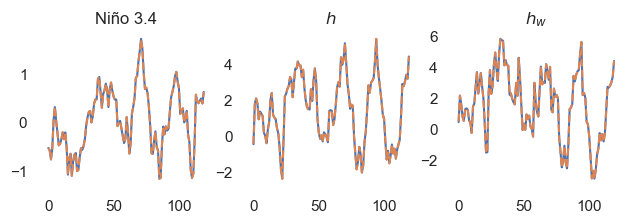

In [6]:
## specify time index for plotting
sample_idx = dict(member=20, time=slice(-120, None))

## set up plot
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2))

## plot Niño 3.4
axs[0].set_title("Niño 3.4")
axs[0].plot(Th_mpi["T_34"].isel(sample_idx))
axs[0].plot(n34_recon.isel(sample_idx), ls="--")

## plot h
axs[1].set_title(r"$h$")
axs[1].plot(Th_mpi["h"].isel(sample_idx))
axs[1].plot(h_recon.isel(sample_idx), ls="--")

## plot hw
axs[2].set_title(r"$h_w$")
axs[2].plot(Th_mpi["h_w"].isel(sample_idx))
axs[2].plot(hw_recon.isel(sample_idx), ls="--")

plt.show()

#### forced

In [7]:
### ground truth
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th_ensemble_mean.nc")
emean_truth = xr.open_dataset(mpi_load_fp)[["T_34", "h"]]

### reconstruction
n34_recon = src.utils.reconstruct_fn(
    components["sst"], emean["sst"], fn=src.utils.get_nino34
)
h_recon = src.utils.reconstruct_fn(
    components["ssh"], emean["ssh"], fn=src.utils.get_RO_h
)
emean_recon = xr.merge([n34_recon.rename("T_34"), h_recon.rename("h")])

## unstack year and month
emean_recon = src.utils.unstack_month_and_year(emean_recon)
emean_truth = src.utils.unstack_month_and_year(emean_truth)

## Check correlation for each month is close
monthly_corr = xr.merge(
    [xr.corr(emean_truth[v], emean_recon[v], dim="year") for v in list(emean_truth)]
)

## compute diff
all_close = (np.abs(1 - monthly_corr) < 1e-5).all()

## print out results
for v in ["T_34", "h"]:
    print(f"{v} all close?: {all_close[v].item()}")

T_34 all close?: True
h all close?: True


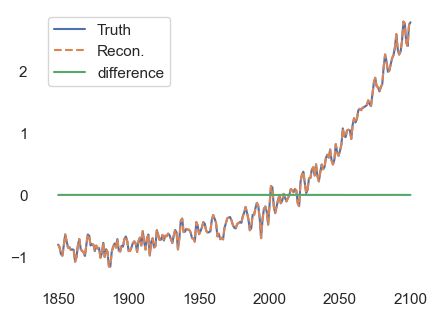

In [8]:
## specify which variable to plot
v = "T_34"

## get plot data
p0 = emean_truth[v].mean("month") - emean_truth[v].mean()
p1 = emean_recon[v].mean("month") - emean_recon[v].mean()
diff = (emean_recon - emean_truth)[v].mean("month")

## make plot
fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(p0.year, p0, label="Truth")
ax.plot(p1.year, p1, ls="--", label="Recon.")
ax.plot(diff.year, diff, label="difference")

ax.legend()
plt.show()

### Test spatial recon

preprocessing function

In [9]:
def preprocess(x):
    """removing 2nd-order polynomial from each calendar month"""

    ## detrending function
    detrend_fn = lambda x: src.utils.detrend_dim(x, dim="time", deg=2)

    ## get anomalies and remainder
    anom = x.groupby("time.month").map(detrend_fn)
    forced = x - anom
    return anom, forced

Get detrended data

In [10]:
def get_forced_diff(forced):
    """given forced component, get difference from clim"""

    ## get climatology
    clim = forced.isel(time=slice(None, 360)).groupby("time.month").mean()

    ## subtract off clim
    return forced.groupby("time.month") - clim

In [11]:
## member to look at
member = rng.choice(scores.member.values).item()

## time idx to reconstruct
# t_idx = -rng.choice(1032)
t_idx = np.arange(-36, -24)
t_ = t_idx[0]

## get ground truth
truth = xr.open_dataset(
    pathlib.Path(
        DATA_FP, f"mpi/ts/cmip6_MPI-ESM1-2-LR_ssp585_r{member}i1p1f1_ts_2015_2100.nc"
    )
)
truth = truth["sst"].compute()

## get reconstruction
proj = scores["sst"].sel(member=member).sel(time=truth.time)

## apply detrending to both and get specified sample
truth_detrend, truth_forced = preprocess(truth)
proj_detrend, proj_forced = preprocess(proj)

## subset in time for anoms
truth_detrend = truth_detrend.isel(time=t_)
proj_detrend = proj_detrend.isel(time=t_)

## average in time for forced component
truth_forced = get_forced_diff(truth_forced).isel(time=t_idx).mean("time")
proj_forced = get_forced_diff(proj_forced).isel(time=t_idx).mean("time")

## reconstruct projections
recon_detrend = src.utils.reconstruct_fn(components["sst"], proj_detrend, fn=identity)
recon_forced = src.utils.reconstruct_fn(components["sst"], proj_forced, fn=identity)

## make sure NaNs match
is_nan = np.isnan(truth_forced)
recon_forced.values[is_nan] = np.nan

Plot reconstruction and difference as sanity check

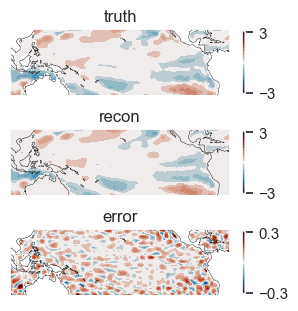

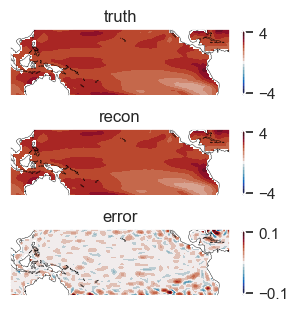

In [12]:
## specify labels
labels = ["ground truth", "reconstruction", "error"]
amps = np.array([3, 3, 0.3])

## anomaly component
kwargs = dict(cmap="cmo.balance", levels=src.utils.make_cb_range(3, 0.3), extend="both")
diff_kwargs = dict(kwargs, levels=src.utils.make_cb_range(0.3, 0.03))
fig, axs, _, _ = src.utils.spatial_comp(
    recon_detrend, truth_detrend, kwargs=kwargs, diff_kwargs=diff_kwargs
)

plt.show()

## forced component
kwargs = dict(cmap="cmo.balance", levels=src.utils.make_cb_range(4, 0.4), extend="both")
diff_kwargs = dict(kwargs, levels=src.utils.make_cb_range(0.1, 0.01))
fig, axs, _, _ = src.utils.spatial_comp(
    recon_forced, truth_forced, kwargs=kwargs, diff_kwargs=diff_kwargs
)

plt.show()

### spatial variance

In [13]:
## compute rolling mean (so ensemble-dim doesn't have zero mean...)
emean, anom = src.utils.separate_forced(scores, n=3)

Gridcell-level

In [14]:
## time index
t_idx = dict(time=slice(-120, None))

## point to check variance at
posn_coords = dict(latitude=-20.5, longitude=200.5)

## compute using custom function
var0_all = src.utils.reconstruct_var(
    scores=anom.isel(t_idx), components=components
).compute()
var0 = var0_all.sel(posn_coords)

## check at single point (reconstruct, then compute variance)
sel_fn = lambda x: x.sel(posn_coords)
recon = src.utils.reconstruct_fn(components, anom.isel(t_idx), fn=sel_fn)
recon_prime = recon - recon.mean(["member", "time"])
var1 = (recon_prime**2).mean(["time", "member"])

## use built-in
var2 = recon.var(["time", "member"])

print(f"All close? {np.allclose(var0.to_dataarray(), var1.to_dataarray())}")
print(f"All close? {np.allclose(var1.to_dataarray(), var2.to_dataarray())}")

All close? True
All close? True


Function of the state (latitude-mean)

In [15]:
## func to get meridional mean
eq_mean = lambda x: x.mean("latitude")

## specify longitude
posn_coords = dict(longitude=200.5)

## compute using custom function
var0_all = src.utils.reconstruct_var(
    scores=anom.isel(t_idx), components=components, fn=eq_mean
).compute()
var0 = var0_all.sel(posn_coords)

## check at single point (reconstruct, then compute variance)
sel_fn = lambda x: eq_mean(x.sel(posn_coords))
recon = src.utils.reconstruct_fn(components, anom.isel(t_idx), fn=sel_fn)
var1 = recon.var(["time", "member"])

print(f"All close? {np.allclose(var0.to_dataarray(), var1.to_dataarray())}")

All close? True


#### synthetic example

In [16]:
m = 100
n = 24

## generate random data
rng = np.random.default_rng()
X = rng.normal(size=(m, n))

## get true variance
varX = np.diag(src.utils.get_cov(X))

## do SVD on data
U, s, Vt = np.linalg.svd(X, full_matrices=False)
S = np.diag(s)

## compute covariance and reconstruct variance
scores_cov = src.utils.get_cov(Vt)
varXhat = np.diag(U @ S @ scores_cov @ S @ U.T)

print(f"All close? {np.allclose(varX, varXhat)}")

All close? True
